In [1]:
pip install -r requirements.txt

  Using cached huggingface_hub-0.21.4-py3-none-any.whl.metadata (13 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached huggingface_hub-0.21.4-py3-none-any.whl (346 kB)
Using cached requests-2.31.0-py3-none-any.whl (62 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.30.2
    Uninstalling huggingface-hub-0.30.2:
      Successfully uninstalled huggingface-hub-0.30.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [2]:
#Loading required libraries
import warnings
warnings.filterwarnings("ignore")

!pip install datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.2
    Uninstalling tqdm-4.66.2:
      Successfully uninstalled tqdm-4.66.2
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.21.4
    Uninstalling huggingface-hub-0.21.4:
      Successfully uninstalled huggingface-hub-0.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Loading the dataset

#df = pd.read_csv('/content/drive/MyDrive/hate_offensive_data.csv')
df = pd.read_csv('hate_offensive_data.csv')
del df['Unnamed: 0']

df['label'] = np.where(df['class']==2, 0, 1)

# Class 0 - Appropriate (Safe)
# Class 1 - Inappropriate (Hateful or offensive)

df.head()

,count,hate_speech,offensive_language,neither,class,tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [5]:
#Text Preprocessing

stop_words = set(stopwords.words('english'))
stop_words.add("rt") # adding rt to remove retweet in dataset

# Removing Emojis
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# Replacing user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)
    return text

# Removing URLs
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

# Removing Unnecessary Symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    text = text.replace(".", '')
    text = text.replace(",", '')
    text = text.replace("#", '')
    text = text.replace(":", '')
    text = text.replace("?", '')
    return text

# Stemming
def stemming(raw_text):
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in raw_text.split()]
    return ' '.join(words)

# Removing stopwords
def remove_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = ' '.join(text)
    return text

def preprocess(data):
    clean = []
    clean = [text.lower() for text in data]
    clean = [change_user(text) for text in clean]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]

    return clean

tweets = list(df['tweet'])
labels = list(df['label'])
clean_tweets = preprocess(tweets)

df_tweets = pd.DataFrame({'tweet': tweets, 'clean_tweet': clean_tweets, 'label': labels})


In [6]:
df_tweets.to_csv('preprocessed_data.csv', index = False)

In [7]:
df_tweets

,tweet,clean_tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain clean hous man alway t...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe 1st place,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf * * * lie right hi tl trash mine bibl s...,1
24779,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart babi drove redneck...,0
24780,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like aint fuc...,1
24781,youu got wild bitches tellin you lies,youu got wild bitch tellin lie,1


In [8]:
#============================ EDA ============================#

In [9]:
#============================ Word Clouds ============================#

def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

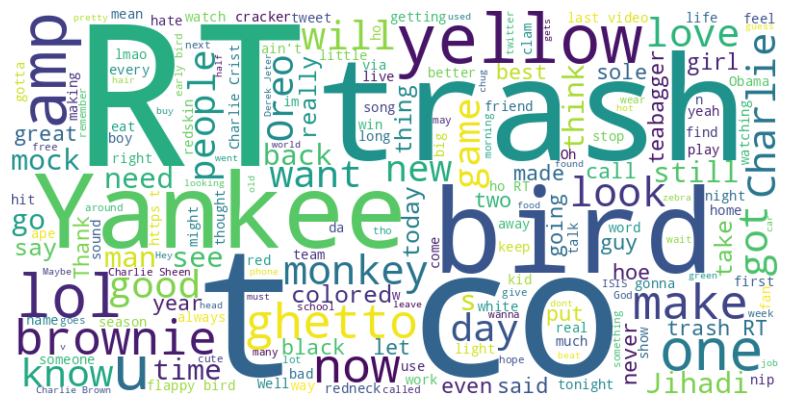

In [10]:
# Word Cloud for Appropriate Tweets (Raw)
generate_wordcloud(' '.join(list(df_tweets[df_tweets['label']==0].tweet)))

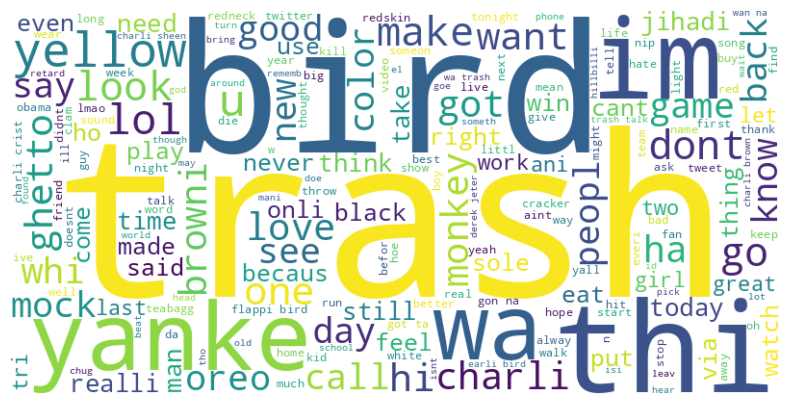

In [11]:
# Word Cloud for Appropriate Tweets (Pre-processed)
generate_wordcloud(' '.join(list(df_tweets[df_tweets['label']==0].clean_tweet)))

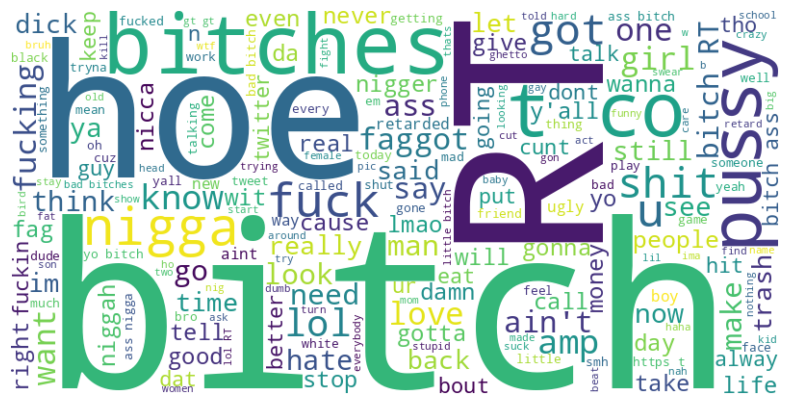

In [12]:
# Word Cloud for Inappropriate Tweets (Raw)
generate_wordcloud(' '.join(list(df_tweets[df_tweets['label']==1].tweet)))

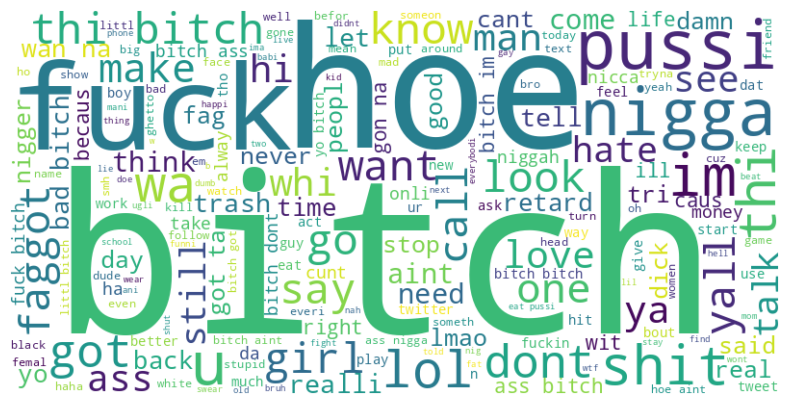

In [13]:
# Word Cloud for Inappropriate Tweets (Pre-processed)
generate_wordcloud(' '.join(list(df_tweets[df_tweets['label']==1].clean_tweet)))

In [14]:
df_tweets['label'].value_counts()

,count
label,
1,20620
0,4163


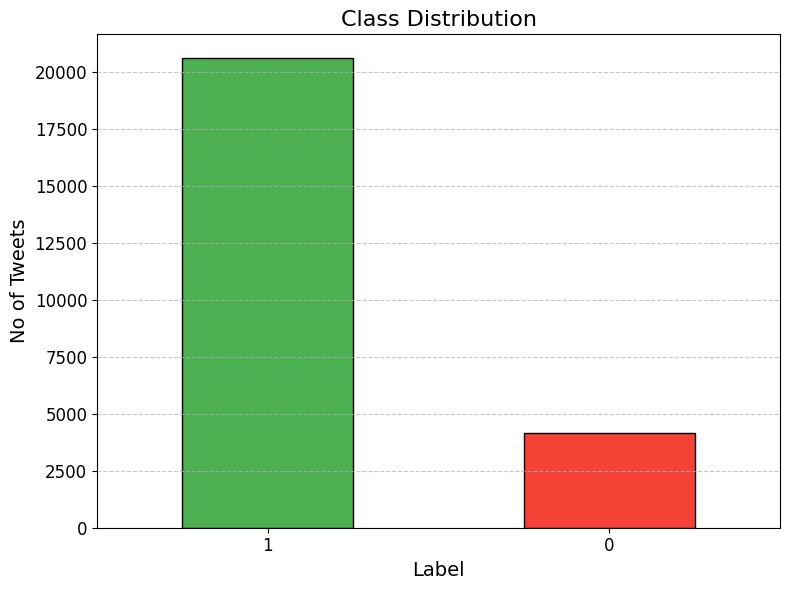

In [15]:
# Class Distribution

class_distribution = df_tweets['label'].value_counts()
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['#4CAF50', '#F44336'], edgecolor='black')
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('No of Tweets', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines to y-axis with dashed style
plt.tight_layout()
plt.show()

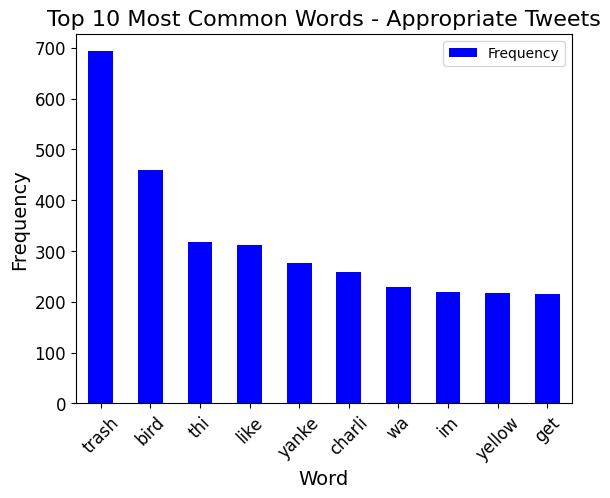

In [16]:
# Bar Plot of Word Frequencies

from collections import Counter

all_tweets = ' '.join(df_tweets[df_tweets['label']==0]['clean_tweet'])
all_tokens = word_tokenize(all_tweets)
word_freq = Counter(all_tokens)
top_words = word_freq.most_common(10)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
top_words_df.plot(kind='bar', x='Word', y='Frequency', color='blue')
plt.title('Top 10 Most Common Words - Appropriate Tweets', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

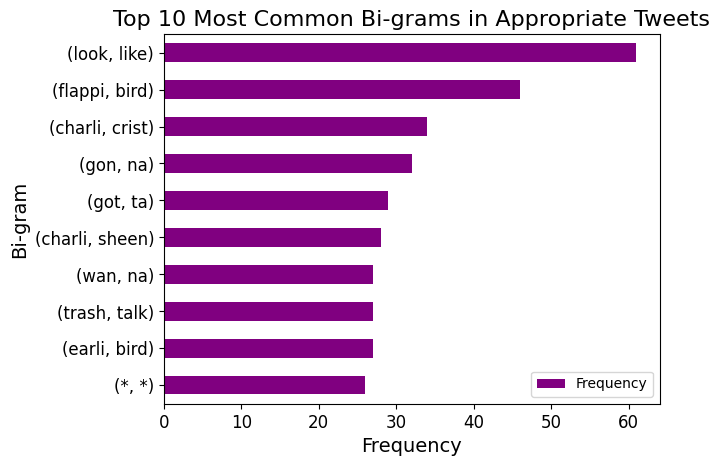

In [17]:
# N-gram Analysis

from nltk.util import ngrams

n = 2
ngram_freq = Counter(ngrams(all_tokens, n))
top_ngrams = ngram_freq.most_common(10)
top_ngrams_df = pd.DataFrame(top_ngrams, columns=['N-gram', 'Frequency'])
top_ngrams_df = top_ngrams_df.sort_values(by='Frequency', ascending=True)
top_ngrams_df.plot(kind='barh', x='N-gram', y='Frequency', color='purple')
plt.title('Top 10 Most Common Bi-grams in Appropriate Tweets', fontsize=16)
plt.xlabel('Frequency'.format(n), fontsize=14)
plt.ylabel('Bi-gram', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()